In [ ]:
# default_exp data.annotated2

In [ ]:
#! pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

# Annotated Timeseries
> Functions and classes to support timeseries containing annotated positions, where an individual annotation denotes a region of interest within a waveform with an associated reference point.  Labels may be uniquely specified per-annotation instance, or may be common among all annotations withing the timeseries


**Motivation**: Electrocardiogram data (ECG/EKG) may contain additional metadata denoting the position of individual heartbeats (qrs position) that can be used to analyze the morphology of individual beats (p-wave, qrs-complex, t-wave) for certain cardiac abnormalities.  Other biosignals such as cardiotocogram (CTG) may also benefit from the analysis of individual events (e.g.: fetal hr decelerations, fetal hr accelerations) with the overall signal.

**Modes of Operation**:

- static:  Preprocess timeseries to extract subsequences where subsequence is defined by offset and with relative to each annotated position (or random subset of annotated positions).  

- dynamic: Batch transform extracts subsequences and associated label for a randomly selected annotation. 

  - **Note:** These classes and functionals are conceptually similar to TSUnwindowedDataset / TSUnwindowedDataset with the key difference that window locatiosn are explicitly specified using a set of annotated positions and that6 each window may have a unique label


Limitations:

- Non-uniform X arrays (ragged numpy arrays) are only supported in static / preprocessing mode.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev import show_doc

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *
from tsai.data.preprocessing import *

In [ ]:
#export
from tsai_ecg.data.synthetic import get_synthetic_sin_data

## Annotation Preprocessing

In [ ]:
#exporti
def _sliding_annotations(all_ann, lengths, width=100, offset=None, limit=None, include_empty=False):
    lengths = [lengths]*len(all_ann) if isinstance(lengths, int) else lengths   # lengths for each row
    offset = offset if offset else -width//2
    offsetR = width + offset
    for i, row_anns in enumerate(all_ann):
        row_anns =  [(idx, e) for idx, e in enumerate(row_anns) 
                     if e+offset >=0 and e+offsetR <  lengths[i]]  # trim overlap
        if len(row_anns) > 0:
            if limit and len(row_anns) > limit:
                random.shuffle(row_anns)
                row_anns = row_anns[:limit]
            for i_a, pos in row_anns:
                yield i, pos+offset, pos+offsetR, i_a
        elif include_empty:
            pos = random.randint(lengths[i]-width)
            yield i, pos, pos+width, None
        else:
            continue

In [ ]:
#exporti
def _compute_new_splits(m, orig_splits):
    return L( L(i for i, old_i in enumerate(m) if old_i in split_set)  
              for split_set in orig_splits)

In [ ]:
#exporti
def _compute_new_folds(m, orig_folds):
    return orig_folds[m]

In [ ]:
#export
@delegates(_sliding_annotations)
def preprocess_extract_annotation_windows(X, anns, y=None, splits=None, folds=None, 
                                          per_ann_label=False, verbose=False, **kwargs):
    """Extracted timeseries subsequences and optionally label relative to annotated positions"""
    lengths = [x.shape[-1] for x in X]
    
    if isinstance(y, NoneType):
        if verbose: print('No Label')
        X_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], i_orig]
            for (i_orig, idx_l, idx_r, _) in _sliding_annotations(anns, lengths, **kwargs)])
        y_win = None
    elif per_ann_label:
        if verbose: print('label per annotation')
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig][i_a], i_orig]
            for (i_orig, idx_l, idx_r, i_a) in _sliding_annotations(anns, lengths, **kwargs)])
        y_win = L(*y_win)
    elif isinstance(y[0], np.ndarray):
        if verbose: print('label is vector')
        assert y[0].shape[-1] == X[0].shape[-1]
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig][idx_l:idx_r], i_orig]
            for (i_orig, idx_l, idx_r, _) in _sliding_annotations(anns, lengths, **kwargs)])
        y_win = np.array(y_win)
    else:
        if verbose: print('label per row')
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig], i_orig]
            for (i_orig, idx_l, idx_r, _) in _sliding_annotations(anns, lengths, **kwargs)])
        y_win = L(*y_win)

    ret = [np.array(X_win)]
    if not isinstance(y_win, NoneType):
        ret.append(y_win)
    
    if not isinstance(splits, NoneType):
        return [*ret, _compute_new_splits(m, splits)]
    elif not isinstance(folds, NoneType):
        return [*ret, _compute_new_folds(m, folds)]
    elif len(ret) == 1:
        return ret[0]
    else:
        return ret

````
Inputs:
      X:       Timeseries data, can be uniform or ragged, with or without channels 
      ans:     List of annotation positions for each waveform  
      y:       optional list label data (nested for per-event lavels)
      width:   window size in samples
      offset:  start of window vs event, window centered by default
      limit:   max windows per timeseries
      per_ann_label:  returns label data corresponding to specific event
      include_empty: include randomly selected window if no annotated positions
      splits:  splits data, will be mapped to windows data if present
      folds:   folds data, will be mapped to windows data if present
      *note: splits and folds are mutually exclusive
Returns:
      X_win:   windowed subsequences (an input row may produce multiple output rows)
      y_win:   labels for subsequences
      folds_win or folds_win: Optional, depending on if splits or folds specified
````

Example: Uniform length timeseries, with channels - Extract subsequences only 

X:(2, 1, 1000)  y:2  anns:2


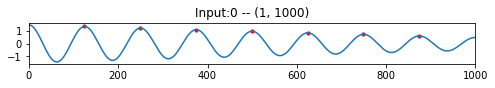

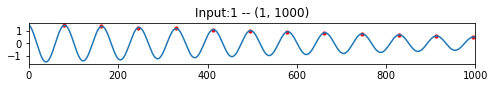

X_win:(10, 1, 150)


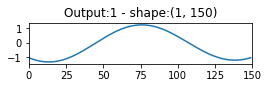

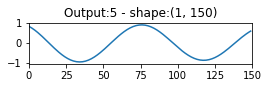

In [ ]:
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=2, dims=3)
print(f'X:{X.shape}  y:{len(y)}  anns:{len(anns)}')

for i, sig in enumerate(X):
    plt.figure(figsize=(8, 0.75))
    plt.title(f'Input:{i} -- {sig.shape}')
    plt.plot(np.arange(sig.shape[-1]), sig[0])
    plt.scatter(anns[i], sig[0][anns[i]], c='r', s=10)
    plt.xlim(0, sig.shape[-1])
    plt.show()

X_win = preprocess_extract_annotation_windows(X, anns, width=150, limit=5)
print(f'X_win:{X_win.shape}')
for i in [1, 5]:
    sig = X_win[i]
    plt.figure(figsize=(4, 0.75))
    plt.title(f'Output:{i} - shape:{sig.shape}')
    plt.plot(np.arange(sig.shape[-1]), sig[0])
    plt.xlim(0, sig.shape[-1])
    plt.show()  

Extract subsequences and per-row labels

X_win:(15, 150)  y_win:15


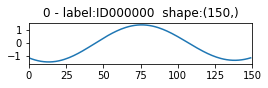

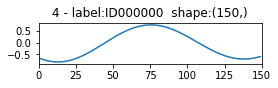

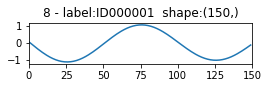

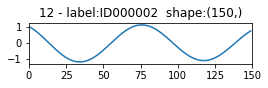

In [ ]:
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3)

w=150
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=w, limit=5)
test_eq(isinstance(X_win, np.ndarray), True)
test_eq(len(X_win.shape), len(X.shape))  # verify dimensions
test_eq(X_win.shape[-1], w)              # verify width
test_eq(len(X_win), len(y_win))  
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')

for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(4, 0.75))
    plt.title(f'{i} - label:{y_win[i]}  shape:{sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show() 

Example: per-annotation labels

X:(3, 1000)  y:3  anns:3


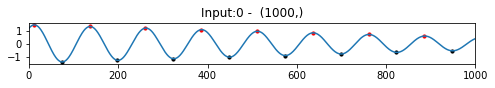

X_win:(15, 150)  y_win:15


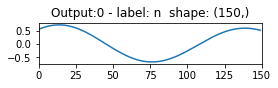

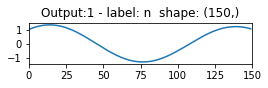

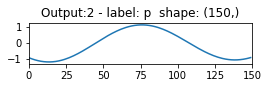

In [ ]:
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, per_ann_label=True)
print(f'X:{X.shape}  y:{len(y)}  anns:{len(anns)}')

i, sig = 0, X[0]
plt.figure(figsize=(8, 0.75))
plt.title(f'Input:{i} -  {sig.shape}')
plt.plot(np.arange(len(sig)), sig)
anns_p = [e for j, e in enumerate(anns[i]) if y[i][j] == 'p']
plt.scatter(anns_p, sig[anns_p], c='r', s=10)
anns_n = [e for j, e in enumerate(anns[i]) if y[i][j] == 'n']
plt.scatter(anns_n, sig[anns_n], c='k', s=10)
plt.xlim(0, len(sig))
plt.show()

X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=150, 
                                                     per_ann_label=True, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(3):
    sig = X_win[i]
    plt.figure(figsize=(4, 0.75))
    plt.title(f'Output:{i} - label: {y_win[i]}  shape: {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()

Example: vector/array labels

X_win:(15, 300)  y_win:15


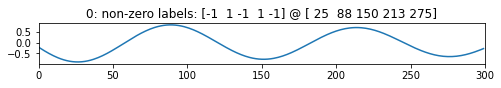

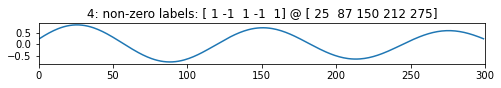

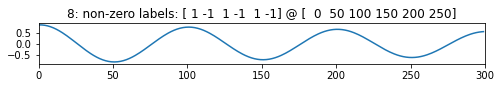

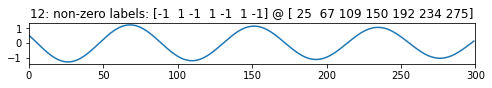

In [ ]:
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, label_is_array=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(0, len(X_win), 4):
    sig = X_win[i]
    yy =  y_win[i]
    yy_pos = np.where(yy!=0)[0]
    yy_subset =  yy[yy!=0]
    plt.figure(figsize=(8, 0.75))
    plt.title(f'{i}: non-zero labels: {yy_subset} @ {yy_pos}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show() 

Example: Splits

In [ ]:
# 2-way split: train, valid
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=20, split_pct=0.2)
X_win, y_win, splits_win = preprocess_extract_annotation_windows(X, anns, y=y, width=150, limit=2, splits=splits)
test_eq(len(splits_win), len(splits))
splits_win

(#2) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39],[14, 15, 16, 17, 20, 21, 36, 37]]

In [ ]:
# 3-way split: train, valid, test
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=20, split_pct=(0.2, 0.15))
X_win, y_win, splits_win = preprocess_extract_annotation_windows(X, anns, y=y, width=150, limit=2, splits=splits)
test_eq(len(splits_win), len(splits))
splits_win

(#3) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 24, 25, 28, 29, 30, 31, 32, 33, 38, 39],[10, 11, 12, 13, 18, 19, 36, 37],[20, 21, 22, 23, 26, 27, 34, 35]]

Example: Folds

In [ ]:
X, y, anns, folds = get_synthetic_sin_data(length=1000, n_sig=20, n_fold=5)
X_win, y_win, folds_win = preprocess_extract_annotation_windows(X, anns, y=y, width=150, limit=2, folds=folds)
test_eq(set(folds), set(folds_win))
folds_win

(#40) [4,4,3,3,0,0,2,2,2,2...]

In [ ]:
#hide

# Unit tests

# Verify lengths of X-array

n_sig, w, dims = 3, 150, 2

# uniform no-channel
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=n_sig, dims=dims)
X_win = preprocess_extract_annotation_windows(X, anns, width=w, limit=5)
test_eq(isinstance(X_win, np.ndarray), True)
test_eq(len(X_win.shape), len(X.shape))  # verify dimensions
test_eq(X_win.shape[-1], w)              # verify width
if dims == 3: test_eq(X_win.shape[-2], 1)
    
# non-uniform no-channel   
X, y, anns = get_synthetic_sin_data(length=(1000, 1100), n_sig=n_sig, dims=dims)
X_win = preprocess_extract_annotation_windows(X, anns, width=w, limit=5)
test_eq(isinstance(X_win, np.ndarray), True)
test_eq(len(X_win[0].shape), len(X[0].shape))  # verify dimensions
test_eq(X_win.shape[-1], w)              # verify width
if dims == 3: test_eq(X_win.shape[-2], 1)

n_sig, w, dims = 3, 150, 3

# uniform with channel
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=n_sig, dims=dims)
X_win = preprocess_extract_annotation_windows(X, anns, width=w, limit=5)
test_eq(isinstance(X_win, np.ndarray), True)
test_eq(len(X_win.shape), len(X.shape))  # verify dimensions
test_eq(X_win.shape[-1], w)              # verify width
if dims == 3: test_eq(X_win.shape[-2], 1)
    
# non-uniform with channel   
X, y, anns = get_synthetic_sin_data(length=(1000, 1100), n_sig=n_sig, dims=dims)
X_win = preprocess_extract_annotation_windows(X, anns, width=w, limit=5)
test_eq(isinstance(X_win, np.ndarray), True)
test_eq(len(X_win[0].shape), len(X[0].shape))  # verify dimensions
test_eq(X_win.shape[-1], w)              # verify width
if dims == 3: test_eq(X_win.shape[-2], 1)

# Verify y output

# per-row labels
X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(isinstance(y_win, L), True)
test_eq(X_win.shape[0], len(y_win))

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, dims=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(isinstance(y_win, L), True)
test_eq(X_win.shape[0], len(y_win))

# per-annotation labels

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, per_ann_label=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, 
                                                     per_ann_label=True, limit=5)
test_eq(isinstance(y_win, L), True)
test_eq(X_win.shape[0], len(y_win))

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, per_ann_label=True, dims=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, 
                                                     per_ann_label=True, limit=5)
test_eq(isinstance(y_win, L), True)
test_eq(X_win.shape[0], len(y_win))


# array/vector labels

X, y, events = get_synthetic_sin_data(length=1000, n_sig=3, label_is_array=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(type(X_win), type(y_win))
test_eq(X_win.shape[0], y_win.shape[0])
test_eq(X_win.shape[-1], y_win.shape[-1])

X, y, events = get_synthetic_sin_data(length=1000, n_sig=3, label_is_array=True, dims=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(type(X_win), type(y_win))
test_eq(X_win.shape[0], y_win.shape[0])
test_eq(X_win.shape[-1], y_win.shape[-1])

X, y, events = get_synthetic_sin_data(length=(1000, 1100), n_sig=3, label_is_array=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(type(X_win), type(y_win))
test_eq(X_win.shape[0], y_win.shape[0])
test_eq(X_win.shape[-1], y_win.shape[-1])

X, y, events = get_synthetic_sin_data(length=(1000, 1100), n_sig=3, label_is_array=True, dims=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(type(X_win), type(y_win))
test_eq(X_win.shape[0], y_win.shape[0])
test_eq(X_win.shape[-1], y_win.shape[-1])

# Multi-label vs single label tests

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(isinstance(y_win[0], (tuple, list, L)), False)

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, has_multi_label=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5)
test_eq(isinstance(y_win[0], (tuple, list, L)), True)
test_eq(isinstance(y_win[0][0], (tuple, list, L)), False)

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, per_ann_label=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, 
                                                     per_ann_label=True, limit=5)
test_eq(isinstance(y_win[0], (tuple, list, L)), False)

X, y, anns = get_synthetic_sin_data(length=1000, n_sig=3, has_multi_label=True, 
                                    per_ann_label=True)
X_win, y_win = preprocess_extract_annotation_windows(X, anns, y=y, width=300, limit=5,
                                                     per_ann_label=True)
test_eq(isinstance(y_win[0], (tuple, list, L)), True)
test_eq(isinstance(y_win[0][0], (tuple, list, L)), False)

## Annotated Data Helper Functions

In [ ]:
#hide
def get_reference_data(n_rows=8, per_ann_label=False, label_is_array=False, n_classes=1000000):
    '''Generates deterministic test data'''
    w = n_rows+2
    X = np.zeros((n_rows, 1, w))
    for i in range(n_rows): X[i, 0, i+1] = i+1
        
    if per_ann_label:
        y = L(L(f'{(i+1)%n_classes}') for i in range(n_rows))
    elif label_is_array:
        y = np.zeros((n_rows, w))
        for i in range(n_rows): y[i, i+1] = i+1
    else:
        #y = L(f'{i+1}' for i in range(n_rows))
        y = L((i+1)%n_classes for i in range(n_rows))
        
    anns = L(L(i+1) for i in range(n_rows))
    splits = L(L(range(n_rows//2)), L(range(n_rows//2, n_rows)))
    return X, y, anns, splits

In [ ]:
#export
def pre_categorize(*args, categorizer=None, splits=None, default=None):
    """Applies categorizer to list or nest list of labels.  Used
    to preprocess per-annotation labels"""
    is_nested = isinstance(args[0][0], (tuple, list, L))
    if categorizer is None: categorizer=Categorize
    if inspect.isclass(categorizer):
        y_train = args[0][splits[0]] if splits else args[0]
        vocab = {y_per for y_row in y_train for y_per in y_row} \
                if is_nested else {y_row for y_row in y_train}
        if default: vocab.add(default)
        c = categorizer()
        c.setups(vocab)
    else:
        c = categorizer
    if is_nested:
        results = [[[c(y_per) for y_per in y_row] for y_row in y_set] for y_set in args]
    else:
        results = [[c(y_row) for y_row in y_set] for y_set in args]
    results = results[0] if len(args) == 1 else results
    return results, c

In [ ]:
# per-row labels
X, y, anns, splits = get_reference_data(n_classes=3)
(yc_train, yc_valid), c = pre_categorize(y[splits[0]], y[splits[1]])
c.vocab, yc_train, yc_valid

([0, 1, 2],
 [TensorCategory(1), TensorCategory(2), TensorCategory(0), TensorCategory(1)],
 [TensorCategory(2), TensorCategory(0), TensorCategory(1), TensorCategory(2)])

In [ ]:
# per-ann labels
X, y, anns, splits = get_reference_data(n_classes=3, per_ann_label=True)
(yc_train, yc_valid), c = pre_categorize(y[splits[0]], y[splits[1]])
c.vocab, yc_train, yc_valid

(['0', '1', '2'],
 [[TensorCategory(1)],
  [TensorCategory(2)],
  [TensorCategory(0)],
  [TensorCategory(1)]],
 [[TensorCategory(2)],
  [TensorCategory(0)],
  [TensorCategory(1)],
  [TensorCategory(2)]])

In [ ]:
#hide
n_classes=3
# Unit test per-row labels
X, y, anns, splits = get_reference_data(n_classes=n_classes)
(yc_train, yc_valid), c = pre_categorize(y[splits[0]], y[splits[1]])

test_eq(len(c.vocab), n_classes)
test_eq(len(yc_train), len(splits[0]))
test_eq(len(yc_valid), len(splits[1]))
test_eq(set(c.vocab), set(y))

# Unit test per-ann labels
X, y, anns, splits = get_reference_data(n_classes=n_classes, per_ann_label=True)
(yc_train, yc_valid), c = pre_categorize(y[splits[0]], y[splits[1]])
test_eq(len(c.vocab), n_classes)
test_eq(len(yc_train), len(splits[0]))
test_eq(len(yc_valid), len(splits[1]))
test_eq(set(c.vocab), set(_y for y_row in y for _y in y_row))

## Annotated Data Transforms

In [ ]:
#export
class TSPerAnnotationGenericClassifier(DisplayedTransform):
    """Common base class supporting slassification of list of Labels"""
    def __init__(self, classifier, default=None, **kwargs):
        assert classifier is not None
        self.classifier = classifier(**kwargs) if inspect.isclass(classifier) else classifier
        self.default=default
             
    @property
    def vocab(self):
        """Returns vocabulary with map"""
        return self.classifier.vocab
    
    @property
    def internal_classifier(self):
        """Returns underlying classifier (TSClassification or TSMultiLabelClassification)"""
        return self.classifier
    
    def setups(self, dsets):
        if self.classifier.vocab is None and dsets is not None: 
            label_values = [label for row in dsets for label in row]
            if self.default: label_values.append(label_values)
            self.classifier.setups(label_values)
            
    def encodes(self, o):
        return L(self.classifier.encodes(oo) for oo in o)
    
    def decodes(self, o):
        return L(self.classifier.decodes(oo) for oo in o)

In [ ]:
show_doc(TSPerAnnotationGenericClassifier.vocab)

<h4 id="TSPerAnnotationGenericClassifier.vocab" class="doc_header"><code>TSPerAnnotationGenericClassifier.vocab</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Returns vocabulary with map

In [ ]:
show_doc(TSPerAnnotationGenericClassifier.internal_classifier)

<h4 id="TSPerAnnotationGenericClassifier.internal_classifier" class="doc_header"><code>TSPerAnnotationGenericClassifier.internal_classifier</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Returns underlying classifier (TSClassification or TSMultiLabelClassification)

In [ ]:
#export 
class TSPerAnnClassification(TSPerAnnotationGenericClassifier):
    """Classifies list of per-annotation labels, returns L(TensorCategory)"""
    @delegates(TSPerAnnotationGenericClassifier.__init__)
    @delegates(TSClassification.__init__)
    def __init__(self, **kwargs):
        """Classifies list of per-annotation labels, returns L(TensorCategory)"""
        super().__init__(TSClassification, **kwargs)

In [ ]:
X, y, anns, splits = get_synthetic_sin_data(length=100, n_sig=100, dims=3, 
                                            split_pct=0.2,per_ann_label=True)

tspac = TSPerAnnClassification()
tspac.setup(y[splits[0]])
tspac.vocab, tspac.internal_classifier

(['n', 'p'],
 Categorize -- {'vocab': None, 'sort': True, 'add_na': False}:
 encodes: (Tabular,object) -> encodes
 (object,object) -> encodes
 decodes: (Tabular,object) -> decodes
 (object,object) -> decodes)

In [ ]:
_y = y[splits[0]][0]
_y, tspac.encodes(_y), tspac.decodes(tspac.encodes(_y))

((#1) ['p'], (#1) [TensorCategory(1)], (#1) ['p'])

In [ ]:
show_doc(TSPerAnnClassification.vocab)

<h4 id="TSPerAnnotationGenericClassifier.vocab" class="doc_header"><code>TSPerAnnotationGenericClassifier.vocab</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Returns vocabulary with map

In [ ]:
#hide
# Unit test
X, y, anns, splits = get_synthetic_sin_data(length=100, n_sig=100, dims=3, 
                                            split_pct=0.2,per_ann_label=True)
tspac = TSPerAnnClassification()
tspac.setup(y[splits[0]])
test_eq(tspac.vocab, ['n', 'p'])
test_eq(isinstance(tspac.internal_classifier, type(TSClassification())), True)
for split_set in splits:
    for s in split_set:
        test_eq(y[s], tspac.decodes(tspac.encodes(y[s])))

In [ ]:
#export  
class TSPerAnnMultiLabelClassification(TSPerAnnotationGenericClassifier):
    """Classifies list of per-annotation multi-labels, 
    returns (L(tensor) contining one-hot encoded values"""
    @delegates(ItemTransform.__init__)
    @delegates(TSMultiLabelClassification.__init__)
    def __init__(self, **kwargs):
        """Classifies list of per-annotation multi-labels, 
        returns (L(tensor) contining one-hot encoded values"""
        super().__init__(TSMultiLabelClassification, **kwargs)

# New



Y Value format Format:
 - List with per-row values
 - Tuple per row (pos_spec, label_spec)
 - pos_spec: (i_start, i_end, [chan], [y_chan])  # using default parser
   - if channel specified, it can be int, slice or "random".  if missing, defaults to all
 - label_spec: 
   - common label
   - vector
   - per-annotation label - label(s) per annotation

#### Limitations
- Must have at least 1 valid Label

#### Approach
- Preprocess Labels
- offset to bounds
- Zip annotations and labels after filtering endpoints

In [ ]:
def y_getter_per_row_label(i, entry, **ignore):
    return entry

def y_getter_per_ann_label(i, entry, default=None, **ignore):
    assert i is not None or default is not None
    return entry[i] if i is not None else default

def y_getter_vector_label(i, entry, offset=None, width=None, y_chan=None):   
    assert offset is not None and width is not None
    if len(entry.shape) > 1:
        if y_chan is None:
            y_chan = slice(entry.shape[0])
        return entry[y_chan, i+offset:i+offset+width]  
    else:
        return entry[i+offset:i+offset+width] 

In [ ]:
X, y, anns, splits = get_reference_data(n_classes=3)
X[0], y[0], anns[0], y_getter_per_row_label(anns[0][0], y[0])

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]), 1, (#1) [1], 1)

In [ ]:
X, y, anns, splits = get_reference_data(n_classes=3, per_ann_label=True)
X[0], y[0], anns[0],  y_getter_per_ann_label(0, y[0])

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]), (#1) ['1'], (#1) [1], '1')

In [ ]:
y_vec = np.arange(100).reshape(10, 10)
y_getter_vector_label(0, y_vec, offset=0, width=3)

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32],
       [40, 41, 42],
       [50, 51, 52],
       [60, 61, 62],
       [70, 71, 72],
       [80, 81, 82],
       [90, 91, 92]])

In [ ]:
y_getter_vector_label(0, y_vec, offset=0, width=3, y_chan=1)

array([10, 11, 12])

In [ ]:
y_getter_vector_label(0, y_vec[1], offset=0, width=3)

array([10, 11, 12])

In [ ]:
def _get_ann_bounds(all_ann, lengths, width=100, offset=None):
    lengths = [lengths]*len(all_ann) if isinstance(lengths, int) else lengths   # lengths for each row
    offset = offset if offset else -width//2
    offsetR = width + offset
    
    bounds = 
    
    for i, row_anns in enumerate(all_ann):
        row_anns =  [(idx, e) for idx, e in enumerate(row_anns) 
                     if e+offset >=0 and e+offsetR <  lengths[i]]  # trim overlap
        if len(row_anns) > 0:
            if limit and len(row_anns) > limit:
                random.shuffle(row_anns)
                row_anns = row_anns[:limit]
            for i_a, pos in row_anns:
                yield i, pos+offset, pos+offsetR, i_a
        elif include_empty:
            pos = random.randint(lengths[i]-width)
            yield i, pos, pos+width, None
        else:
            continue

SyntaxError: invalid syntax (<ipython-input-39-dbef9b777f45>, line 6)

In [ ]:
#export
class TSAnnotationWindow(ItemTransform):
    """Extract subsequence corresponding to annotation and selects appropriate label"""
    @delegates(ItemTransform.__init__)
    def __init__(self, width=100, offset=None, x_out_type=None, y_out_type=None, 
                 default_label=None, verbose=False, classifier=None, **kwargs):
        """Extract subsequence corresponding to annotation and selects appropriate label"""
        self.width, self.offset, self.verbose = width, offset, verbose
        self.x_out_type, self.y_out_type, self.default_label = x_out_type, y_out_type, default_label
        self.y_mode, self.classifier = None, classifier
        super().__init__(**kwargs)
        

    def _setup(self, o):
        o_x, o_y = o            
        self.is_batch =  len(o_x.data.shape) == 3 and o_x.data.shape[0] > 1
        if self.is_batch:
            o_y = o_y[0]  # loot at first row of y values when assessing type
            
        if isinstance(o_y, (TensorCategory, TensorMultiCategory)):
            self.y_mode = 'common'
        elif isinstance(o_y, (TSTensor, Tensor)):
            self.y_mode = 'tensor'
            if not self.y_out_type and isinstance(o_y, TSTensor):
                self.y_out_type = TSTensor
        elif isinstance(o_y, np.ndarray):
            self.y_mode = 'numpy'
            if not self.y_out_type:
                self.y_out_type = TSTensor
        elif isinstance(o_y, (list, tuple, L)):
            self.y_mode = 'per_ann'
        else:
            raise Exception(f'Unknown y type: {type(o_y)}')   
        if self.x_out_type is None:
            self.x_out_type = TSTensor 
        
        
    def encodes(self, o):  
        o_x, o_y = o  
        if self.y_mode is None:
            self._setup(o)
        #o_y = L(*o_y) if isinstance(o_y, list) else o_y
        
        windows = [z for z in _sliding_annotations(o_x.ann, o_x.data.size()[-1], width=self.width, 
                                              offset=self.offset, include_empty=True, limit=1)]
        output_x = torch.stack([o_x[i_row, :, idxL:idxR] for i_row, idxL, idxR, idx_a in windows] )
        output_x = self.x_out_type(output_x)
            
        if self.y_mode == 'common':
            output_y = o_y
        elif self.y_mode == 'tensor':
            output_y = torch.stack([o_y[i_row, ..., idxL:idxR] 
                                    for i_row, idxL, idxR, idx_a in windows] )
            if self.y_out_type: 
                output_y = self.y_out_type(output_y)
            elif isinstance(o_y, TSTensor):
                output_y = o_y.new(output_y)
        elif self.y_mode == 'numpy':
            output_y = np.vstack([o_y[i_row][..., idxL:idxR] 
                                    for i_row, idxL, idxR, idx_a in windows] )
            if self.y_out_type: 
                output_y = self.y_out_type(output_y)
            elif isinstance(o_y, TSTensor):
                output_y = o_y.new(output_y)     
        elif self.y_mode == 'per_ann':
            default_label = self.classifier.encode(self.default_label) \
                            if self.classifier and self.default_label else None
            output_y =  [o_y[i_row][idx_a] if idx_a else default_label if default_label \
                         else o_y[i_row][idx_a]
                         for i_row, idxL, idxR, idx_a in windows]
        else:
            raise exception(f'unknown y_mode: {self.y_mode}')
            
        if self.y_mode in ('per_ann', 'common'):
            if self.y_out_type: 
                output_y = self.y_out_type(output_y)
            else:
                output_y = output_y[0].new(output_y)
            
        return output_x, output_y

In [ ]:
show_doc(TSAnnotationWindow.__init__)

````
Inputs:
    width:         Width of extracted subsequence, 
    offset:        Start of subsequence relative to annotated position, 
                   default -width//2 
    default_label: When used with per-annotation labels, this is the label 
                   returned with randomly selected subsequence when no valid
                   annotated position
    classifier:    Used to encode default-label, if needed
    x_out_type:    Overrides X output type, if X is non-tensor, defaults
                   to TSTensor
    y_out_type:    Overrides y output type, default to same as input type for 
                   per-row and per-annotation labels, uses TSTensor  
                   for array/vector labels if not already in tensor format
````

Example:  TSAnnotationWindow with categorized per-row labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2)
dls = get_ats_dls(X, y=y, anns=anns, splits=splits, tfms=[None, Categorize])

xb,yb = next(iter(dls.valid))
f, ax = plt.subplots(figsize=(8, 1))
_ = xb.show(ax=ax)

tsaw = TSAnnotationWindow(width=width)
xo, yo = tsaw((xb, yb), split_idx=0)
fig, ax = plt.subplots(figsize=(4, 2))
_ = xo.show(ax=ax)
xo, yo

In [ ]:
#hide
test_eq(xb.size()[:-1], xo.size()[:-1])
test_eq(xo.size()[-1], tsaw.width)
test_eq(yo, yb[0].new(yb))   # should be same labels

Example: TSAnnotationWindow with categorized per-annotation labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2,per_ann_label=True)
y_cat, c = pre_categorize(y, splits=splits)
dls = get_ats_dls(X, y=y_cat, anns=anns, splits=splits, tfms=[None, None])

xb,yb = next(iter(dls.valid))
f, ax = plt.subplots(figsize=(8, 1))
_ = xb.show(ax=ax)

tsaw = TSAnnotationWindow(width=width)
xo, yo = tsaw((xb, yb), split_idx=0)
for i in range(0,10, 3):
    fig, ax = plt.subplots(figsize=(2, 1.25))
    plt.title(c.decodes(yo[i]))
    _ = xo[i].show(ax=ax)
xo[0], yo[0]

In [ ]:
#hide
test_eq(xb.size()[:-1], xo.size()[:-1])
test_eq(xo.size()[-1], tsaw.width)
test_eq(len(yo), len(yb))   # should be same labels
test_eq(len({int(_z) for _z in yo}), 2)   # only 2 classes

Example: TSAnnotationWindow vector labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2, label_is_array=True)
dls = get_ats_dls(X, y=y, anns=anns, splits=splits, tfms=[None, ToTSTensor])
xb,yb = next(iter(dls.valid))

f, ax = plt.subplots(figsize=(8, 2))
plt.title('vector label')
_ = yb[0].show(ax=ax)

tsaw = TSAnnotationWindow(width=width)
xo, yo = tsaw((xb, yb), split_idx=0)
fig, ax = plt.subplots(figsize=(4, 2))
plt.title('subsequence vector label')
_ = yo[0].show(ax=ax)
xo, yo

In [ ]:
#hide
test_eq(xb.size()[:-1], xo.size()[:-1])
test_eq(xo.size()[-1], tsaw.width)
test_eq(yo.shape[0], len(yb))   # should be same labels
test_eq(yo.shape[-1], tsaw.width)

## End-to-End Support

In [ ]:
#exporti
def _tfm_to_list(entry):
    if isinstance(entry, (tuple, list, L)):
        return list(*entry)
    elif entry:
        return [entry]
    else:
        return []

In [ ]:
#exporti
def _merge_transforms(prefix_tfms, existing_tfms):
    prefix_tfms = [_tfm_to_list(prefix_tfms[0]) , _tfm_to_list(prefix_tfms[1])] \
                   if prefix_tfms else [[], []]
    existing_tfms = [tfm_to_list(existing_tfms[0]) , tfm_to_list(existing_tfms[1])] \
                     if existing_tfms else [[], []]
    return [prefix_tfms[0]+existing_tfms[0], prefix_tfms[1]+existing_tfms[1]]

In [ ]:
#export
@delegates(get_ats_dls)
def get_ats_dls_with_transforms(X, y=None, per_ann_label=False,
                                window_width=100, window_offset=None,
                                default_label=None,tfms=None, batch_tfms=None,
                                **kwargs):
    """Returns TSAnnotatedDataLoaders with pre-configured transforms based on
    label types.  Also includes classifier to decode/encode individual label"""
    is_vector = isinstance(y[0], (np.ndarray, Tensor))
    
    if is_vector:
        tfm_y = ToTSTensor
        classifier = None
    elif per_ann_label: # per_ann
        if isinstance(y[0][0], (tuple, list, L)): # multi-category
            tfm_y = TSPerAnnMultiLabelClassification(default=default_label)
        else:
            tfm_y = TSPerAnnClassification(default=default_label)
        classifier = tfm_y.internal_classifier
    else:   # per-row
        if isinstance(y[0], (tuple, list, L)): # multi-category
            tfm_y = TSMultiLabelClassification()
        else:
            tfm_y = TSClassification()
        classifier = tfm_y
        
    if per_ann_label and default_label:
        tsaw = TSAnnotationWindow(width=window_width, offset=window_offset,
                                  default_label=default_label, 
                                  classifier=tfm_y.internal_classifier)
    else:
        tsaw = TSAnnotationWindow(width=window_width, offset=window_offset)
    
    tfms = _merge_transforms([None, tfm_y], tfms)
    batch_tfms = _tfm_to_list(tsaw) + _tfm_to_list(batch_tfms)
    dls = get_ats_dls(X, y=y, tfms=tfms, batch_tfms=batch_tfms, **kwargs)
    return dls, classifier

In [ ]:
show_doc(get_ats_dls_with_transforms)

Example: Per-row labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2)
dls, c = get_ats_dls_with_transforms(X, y=y, anns=anns, splits=splits, bs=2,
                                  window_width=width, window_offset=-width//2)

xb,yb = next(iter(dls.train))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Train: {c.decode(yb[0])}')
_ = xb.show(ax=ax)

xb,yb = next(iter(dls.valid))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Valid: {c.decode(yb[0])}')
_ = xb.show(ax=ax)

xb,yb

Example:  Per-annotation labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2, per_ann_label=True)
dls, c = get_ats_dls_with_transforms(X, y=y, anns=anns, splits=splits, bs=2,
                                  per_ann_label=True,
                                  window_width=width, window_offset=-width//2)

xb,yb = next(iter(dls.train))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Train: {c.decode(yb[0])}')
_ = xb.show(ax=ax)

xb,yb = next(iter(dls.valid))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Valid: {c.decode(yb[0])}')
_ = xb.show(ax=ax)

xb,yb

Example: Array/Vector labels

In [ ]:
width=120
X, y, anns, splits = get_synthetic_sin_data(length=1000, n_sig=1000, dims=3, 
                                            split_pct=0.2, label_is_array=True)
dls, c = get_ats_dls_with_transforms(X, y=y, anns=anns, splits=splits, bs=2,
                                  window_width=width, window_offset=-width//2)

xb,yb = next(iter(dls.train))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Train: X')
_ = xb[0].show(ax=ax)
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Train: Y')
_ = yb[0].show(ax=ax)

xb,yb = next(iter(dls.valid))
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Valid: X')
_ = xb[0].show(ax=ax)
f, ax = plt.subplots(figsize=(3, 1))
plt.title(f'Valid: Y')
_ = yb[0].show(ax=ax)

xb,yb